# <span style="color: green;">Cross-correlating GW and Galaxy catalogs</span>

# <span style="color: red;">Questions:</span>

<ol>
  <li>Cell 11 - Shouldn't put the ra function instead of rr to actually calculate the spherical harmonics in the desired scale?</li>
  <li>Markdown spectra cell - How does all this calculation remains meaningful when we're marginalizing over all of the possible values of bias for BHs and GW? It looks like a cycle! the only difference between the cross spectras and the auto spectras arises from their difference in the bias value at the different r!! If we're not going to care about the bias then I don't understand what is so special about the GW  observations!! It's just some higher statistics of the underlying matter field itself doesn't really have to do anything with the GW catalog!</li>
</ol>

In [1]:
using TwoFAST
using Dierckx
using DelimitedFiles
using QuadGK
using LinearAlgebra
using SpecialFunctions
using SparseArrays

# Loading the power spectrum to be projected onto the spherical harmonics:

In [2]:
path = homedir() * "/.julia/packages/TwoFAST/"
path *= readdir(path)[1]
path *= "/test/data/planck_base_plikHM_TTTEEE_lowTEB_lensing_post_BAO_H070p6_JLA_matterpower.dat"
d = readdlm(path, comments=true)
pk = Spline1D(d[:,1], d[:,2])


N = 4096    # number of points to use in the Fourier transform
kmax = 1e3  # maximum k-value
kmin = 1e-5 # minimum k-value
chi0 = 1e-3   # minimum r-value (should be ~1/kmax)
q = 1.1; #What is it exactly?!

#Neal's initial condition:
#N = 4096;
#kmin = 1e-5;
#kmax = 1e3;


# First we calculate the two point correlation function as described below:
## $ \xi_l^v(r) = \int_0^{\infty} \frac{k^2 dk}{2\pi^2} P_k \frac{j_l(kr)}{(kr)^v} $


In [3]:

print("ξ(r), ℓ=0, ν=0: ")
r00, xi00 = xicalc(pk, 0, 0; N=N, kmin=kmin, kmax=kmax, r0=chi0)

print("ξ(r), ℓ=0, ν=-2:")
r, xi0m2 = xicalc(pk, 0, -2; N=N, kmin=kmin, kmax=kmax, r0=chi0)

ξ(r), ℓ=0, ν=0: ξ(r), ℓ=0, ν=-2:

([0.001, 0.0010045073642544625, 0.0010090350448414473, 0.0010135831333340658, 0.0010181517217181819, 0.0010227409023942737, 0.0010273507681793025, 0.0010319814123085885, 0.001036632928437698, 0.0010413054106443369  …  95602.39010953065, 96033.30490535141, 96466.16199111959, 96900.9701214438, 97337.73809039182, 97776.47473167058, 98217.18891880369, 98659.88956530999, 99104.58562488579, 99551.28609158496], [6.231495803216023, 6.284801775671147, 6.338536236235863, 6.392702125504542, 6.447302394647362, 6.502340005240893, 6.557817929092735, 6.613739148057433, 6.670106653850142, 6.726923447851813  …  5.724877996684647, 5.7740885898887, 5.823699126134334, 5.8737124337912725, 5.9241313532169135, 5.974958736657006, 6.026197448103745, 6.077850363183417, 6.129920369008597, 6.182410364052219])

# Now one may want to calculate the $M_{ll}$ which is:

## The final step of projecting onto the spherical harmonics is to actually find the $C_l$ coefficients as follows:


## <span style="color: green;">$C_l(r, r') = \frac{2}{\pi} \int k^2 dk \ P(k) \ j_l(kr) \ j_l(kr')$</span>

## To calculate this one may want to first calculate the fourier transform of the multiplication of two spherical bessel functions:

## $ e^{q\sigma} j_l(\alpha e^{\sigma}) \ j_l'(\beta e^{\sigma}) = \int \frac{dt}{2 \pi} e^{it \sigma} M_{ll'}^{q}(t,R)$

In [4]:
nl=300; ell=[i for i in 1:nl ]; #500 
nR=184; RR = [10^((i-nR)/512) for i in 1:nR ]; #384

#TwoFAST example
#ell = [42]  # only ell=42 for this run
#RR = [0.6, 0.7, 0.8, 0.9, 1.0]

## Next step can be skipped if you already ran it once and the cache file exists

In [5]:
# calculate M_ll at high ell, result gets saved to a file:
#This calculates the multiplication of two besse functions
f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
write("out/F21EllCache", f21cache)

# calculate all M_ll, result gets saved to a file:
mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
write("out/MlCache", mlcache)

  q=1.1, R=0.43911485066998085:	  0.162066 seconds (229.07 k allocations: 35.594 MiB, 34.71% compilation time)
  q=1.1, R=0.44109410125149434:	  0.137535 seconds (224.06 k allocations: 35.176 MiB, 20.75% gc time)
  q=1.1, R=0.44308227303632963:	  0.125343 seconds (223.84 k allocations: 35.134 MiB, 11.30% gc time)
  q=1.1, R=0.44507940623559955:	  0.123091 seconds (224.91 k allocations: 35.323 MiB, 6.41% gc time)
  q=1.1, R=0.44708554124166333:	  0.118189 seconds (224.20 k allocations: 35.206 MiB, 5.58% gc time)
  q=1.1, R=0.449100718628943:	  0.115656 seconds (224.49 k allocations: 35.246 MiB)
  q=1.1, R=0.45112497915474453:	  0.117691 seconds (224.34 k allocations: 35.223 MiB, 6.72% gc time)
  q=1.1, R=0.4531583637600818:	  0.121376 seconds (224.10 k allocations: 35.181 MiB, 6.00% gc time)
  q=1.1, R=0.4552009135705047:	  0.124167 seconds (224.59 k allocations: 35.268 MiB, 6.18% gc time)
  q=1.1, R=0.4572526698969311:	  0.121768 seconds (224.22 k allocations: 35.209 MiB, 6.50% gc time

  q=1.1, R=0.9389798010476961:	  0.275390 seconds (225.34 k allocations: 34.090 MiB, 2.89% gc time)
  q=1.1, R=0.9432121250386007:	  0.292848 seconds (225.32 k allocations: 34.085 MiB)
  q=1.1, R=0.9474635256553754:	  0.275674 seconds (225.34 k allocations: 34.092 MiB, 2.43% gc time)
  q=1.1, R=0.9517340888833214:	  0.322815 seconds (225.34 k allocations: 34.092 MiB, 2.23% gc time)
  q=1.1, R=0.9560239010953075:	  0.348934 seconds (225.35 k allocations: 34.097 MiB, 2.33% gc time)
  q=1.1, R=0.9603330490535164:	  0.423555 seconds (225.38 k allocations: 34.095 MiB, 2.15% gc time)
  q=1.1, R=0.9646616199111993:	  0.407230 seconds (225.41 k allocations: 34.103 MiB)
  q=1.1, R=0.9690097012144389:	  0.407680 seconds (225.34 k allocations: 34.090 MiB, 1.88% gc time)
  q=1.1, R=0.9733773809039202:	  0.467855 seconds (225.46 k allocations: 34.112 MiB, 1.46% gc time)
  q=1.1, R=0.9777647473167089:	  0.500301 seconds (225.40 k allocations: 34.104 MiB, 1.34% gc time)
  q=1.1, R=0.9821718891880378:

ell 135, elapsed: 0.4570000171661377
ell 134, elapsed: 0.5390000343322754
ell 133, elapsed: 1.5149998664855957
ell 132, elapsed: 0.20600008964538574
ell 131, elapsed: 0.19000005722045898
ell 130, elapsed: 0.2070000171661377
ell 129, elapsed: 0.1809999942779541
ell 128, elapsed: 0.10900020599365234
ell 127, elapsed: 0.20099997520446777
ell 126, elapsed: 0.18999981880187988
ell 125, elapsed: 0.18900012969970703
ell 124, elapsed: 0.20199990272521973
ell 123, elapsed: 2.005000114440918
ell 122, elapsed: 0.30100011825561523
ell 121, elapsed: 0.1979999542236328
ell 120, elapsed: 0.13199996948242188
ell 119, elapsed: 0.1529998779296875
ell 118, elapsed: 0.1100001335144043
ell 117, elapsed: 0.1099998950958252
ell 116, elapsed: 0.12400007247924805
ell 115, elapsed: 0.24099993705749512
ell 114, elapsed: 0.11400008201599121
ell 113, elapsed: 0.12100005149841309
ell 112, elapsed: 0.2109999656677246
ell 111, elapsed: 0.437999963760376
ell 110, elapsed: 0.5320000648498535
ell 109, elapsed: 0.4589998

200

## Now here we calculated the multiplication of two bessel functions. This can be used to read directly now and calculate the C_l's the coefficients of the spherical harmonics that we were looking for. 

### The net step is just here to help us smallen our arrays a little bit more by taking a look at the values of r!
## We just want the power spectrum on the scale $\ 1<r<10K\  MPc/h$ 

In [5]:
rr = calcwljj(pk, RR; ell=[-1], kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q);

In [6]:
rr[1537]

0.9999999999999998

In [7]:
rr[3585]

9999.99999999997

In [8]:
length(rr)

4096

In [9]:
#What does i exactly corresponds to here?
#we just want the rs between 1 to 10000Mpc/h
imin=1537;
imax=3585;
#Now we just want to make an array for the C_ls which its size id eqaul to imin to imax 
ra = rr[imin:imax]
nr=length(ra);
wl=zeros(nr,nr,nl);

#As a reminder nl was jsut the size of the ell array

# Actually calculating the $C_l$s

In [10]:
#finding wij's
function outfunc(wjj, ell, rr, RR)
    nR=length(RR);
    l=Int(ell);
    
    #nr is here because we're only interested in the matrix elements between two specific scale and not everything
    
    for i in 1:nr
        jmin=max(1,i+1-nR);
        wl[i,jmin:i,l] = (wjj[1])[i+imin-1,(nR-(i-jmin)):nR];
        wl[jmin:i,i,l] = wl[i,jmin:i,l]';
        #' means adjont
    end
    #end for each for loop or any conditional thing
end

#Now the next will calculate the spherical harmonics with the cache it had made from the multiplication of two bessel 
#functions and then here the outfunc will help us in the term that RR would be the rr array but only from the kmin to kmax
#then we give the power spectrum itself Pk to actually calculate the spherical harmonics for it
#outfunct then will put the input in the array wij as defined

rr = calcwljj(pk, RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin");



# w00 = Array{Float64}(undef, N, length(RR))
# w02 = Array{Float64}(undef, N, length(RR))
# function outfunc(wjj, ell, rr, RR)
#     if ell == 42
#         w00[:,:] = wjj[1]
#         w02[:,:] = wjj[2]
#     end
# end
# rr = calcwljj(pk, RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin")

  0.324384 seconds (31 allocations: 66.000 KiB)
make_phi():   0.002090 seconds (50 allocations: 274.609 KiB)
 14.711786 seconds (8.69 M allocations: 1.955 GiB, 1.40% compilation time)
tskip:       0.000152 sec (0 allocations: 0 byte, 0.0% gc time)
tread:       5.550006 sec (15 allocations: 4.961 KB, 0.0% gc time)
tmultphi:    1.112047 sec (342 allocations: 16.844 KB, 0.0% gc time)
tbrfft:      3.501949 sec (0 allocations: 0 byte, 0.0% gc time)
tmultprefac: 1.114139 sec (0 allocations: 0 byte, 0.0% gc time)
toutfunc:    3.450464 sec (8.686 M allocations: 1.955 GB, 0.0% gc time)


## Now everything above was actually another step to save the result of wl which is our $C_l$ objects and also calculte the scale array. To this point now we have our spherical harmonics and $C_l$ coefficients we just need to apply a binning and calculate the covarinace matrix and the Fisher matrix from it


In [11]:
wl

2049×2049×300 Array{Float64, 3}:
[:, :, 1] =
 15.4627  15.437   15.4034  15.3646  15.3219  …   0.0          0.0
 15.437   15.4226  15.3969  15.3634  15.3247      0.0          0.0
 15.4034  15.3969  15.3826  15.3569  15.3234      0.0          0.0
 15.3646  15.3634  15.3569  15.3426  15.317       0.0          0.0
 15.3219  15.3247  15.3234  15.317   15.3027      0.0          0.0
 15.2758  15.282   15.2848  15.2835  15.2771  …   0.0          0.0
 15.2269  15.236   15.2422  15.2449  15.2437      0.0          0.0
 15.1756  15.1872  15.1962  15.2024  15.2051      0.0          0.0
 15.122   15.1359  15.1475  15.1565  15.1627      0.0          0.0
 15.0665  15.0825  15.0963  15.1079  15.1169      0.0          0.0
 15.0093  15.027   15.0429  15.0567  15.0683  …   0.0          0.0
 14.9504  14.9699  14.9876  15.0035  15.0173      0.0          0.0
 14.8901  14.9111  14.9305  14.9482  14.964       0.0          0.0
  ⋮                                           ⋱               
  0.0      0.0      0

In [12]:
size(ra)

(2049,)

In [13]:
size(wl)

(2049, 2049, 300)

In [14]:
size(ell)

(300,)

In [15]:
wl[:,1,:]

2049×300 Matrix{Float64}:
 15.4627  7.23982  4.31437  2.90932  2.11523  …   0.00151628    0.00150458
 15.437   7.22622  4.3046   2.90131  2.10821      0.000827776   0.000819439
 15.4034  7.20522  4.28775  2.88649  2.09461      0.000283808   0.000279733
 15.3646  7.17941  4.26642  2.86747  2.07705      8.46861e-5    8.31369e-5
 15.3219  7.15001  4.24182  2.84544  2.05674      2.72797e-5    2.66798e-5
 15.2758  7.11767  4.21459  2.82106  2.03428  …   6.04036e-6    5.86282e-6
 15.2269  7.08288  4.18522  2.79479  2.01018      2.33173e-6    2.26255e-6
 15.1756  7.04599  4.15405  2.76698  1.98475      5.92097e-7    5.76049e-7
 15.122   7.00728  4.12136  2.73791  1.95827      2.07796e-8    1.27825e-8
 15.0665  6.96698  4.08738  2.70778  1.93094      1.28487e-7    1.27711e-7
 15.0093  6.92528  4.05229  2.67678  1.90295  …  -3.3553e-8    -3.41209e-8
 14.9504  6.88235  4.01625  2.64506  1.87442      3.24117e-8    3.16114e-8
 14.8901  6.83833  3.97939  2.61276  1.84549     -2.19384e-8   -2.12715e

### $W_l$ here is actually $C_l(r,r')$ that's the reason for its shape! we have 300 l values for 2049 r values which should run for all of the r and r' and thus will result into a (2049, 2049, 300) matrix.

In [16]:
function diagonals(A)
    n = size(A,1)
    r = size(A,3)
    out = zeros(n,r)
    for j=1:n
        out[j,:]=A[j,j,:]
    end
    return out;
end;


## Just getting the values of $C_l$ for $r'=r$

In [17]:
wl_diag_plate = diagonals(wl)

2049×300 Matrix{Float64}:
 15.4627      7.23982     4.31437     …  0.00152809  0.00151628  0.00150458
 15.4226      7.22367     4.30554        0.00153028  0.00151846  0.00150677
 15.3826      7.20753     4.29673        0.00153245  0.00152063  0.00150893
 15.3426      7.19142     4.28793        0.00153461  0.00152279  0.00151109
 15.3027      7.17532     4.27914        0.00153675  0.00152493  0.00151322
 15.2629      7.15924     4.27035     …  0.00153888  0.00152705  0.00151534
 15.2231      7.14318     4.26157        0.00154099  0.00152916  0.00151745
 15.1833      7.12714     4.2528         0.00154308  0.00153125  0.00151954
 15.1436      7.11112     4.24404        0.00154516  0.00153332  0.00152161
 15.104       7.09511     4.23529        0.00154722  0.00153538  0.00152367
 15.0644      7.07912     4.22655     …  0.00154927  0.00153743  0.00152571
 15.0249      7.06315     4.21782        0.00155129  0.00153946  0.00152774
 14.9855      7.0472      4.20909        0.00155331  0.0015414

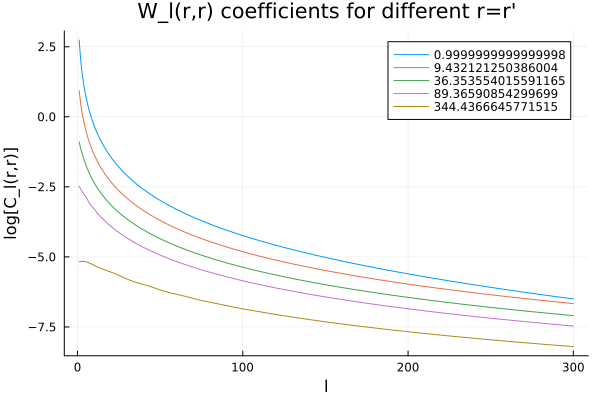

In [18]:
using Plots
plot(ell, [log.(wl_diag_plate[1,:]) log.(wl_diag_plate[500,:]) log.(wl_diag_plate[800,:]) log.(wl_diag_plate[1000,:]) log.(wl_diag_plate[1300,:])], label=[ra[1] ra[500] ra[800] ra[1000] ra[1300]])
#100,200

#plot!(xscale=:log10, yscale=:log10, minorgrid=true)
#ylims!(1e+0, 1e+4)
#xlims!(0, 100)
title!("W_l(r,r) coefficients for different r=r'")
xlabel!("l")
ylabel!("log[C_l(r,r)]")

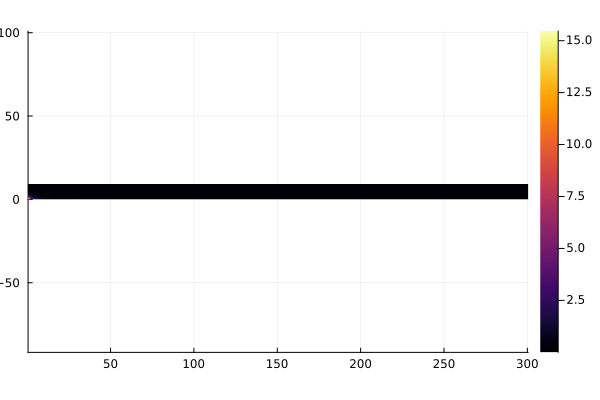

In [19]:
using Unitful, Plots

xs = ell #[string("x", i) for i = 1:10]
ys = log.(ra) #[string("y", i) for i = 1:4]
z = wl_diag_plate #float((1:4) * reshape(1:10, 1, :)) * u"km"
heatmap(xs, ys, z, aspect_ratio=1)

## Everything that we've done so far was to convert the linear power spectrum of matter $P_m(k)$ to power spectrum in terms of bessel functions and spherical harmonics. "Spherically projected power spectrum."

**One can calculate it using the following:**

### $C_{l,matter}(r,r') = \frac{2}{\pi}\ \int k^2 dk j_l(kr) \ j_l^*(kr') P_m(k)$

The ultimate goal fo this notebook is to transform from $P(k)$ to $C_l(r)$. This reads in linear matter $P(k)$, and then computes $C_l(r_1,r_2)$ at $N$ points spaced logarithmically in $r$.  Then, using an assumed cosmology (including $h$), we convert that to binned $C_l(z_1,z_2)$ for galaxies, $C_l(d_1,d_2)$ for BH mergers, and $C_l(z_1,d_2)$ for the cross-spectra, for some assumed distance errors $\sigma_d$ for the BH mergers.

Having the matter power spectrum one can use the following relations to write the power spectrum for the Galaxy catalog and the gravitational wave events:

### $\delta_{Galaxy}(r) = b_{Galaxy}(r) \ \delta_m$
###  $\delta_{GW}(r) = b_{GW}(r) \ \delta_m$

and now having this one can write the auto-spectra for each of the catalogs and the cross-spectra respectively as follows:

## Auto-Spectra:

Writing from the scratch:
####  $<\delta n_{l' m',Galaxy}(r')^* \ \delta n_{lm, Galaxy}(r)>  \ =\  b_{Galaxy}(r')b_{Galaxy}(r) <\delta n_{l' m',matter}(r')^* \ \delta n_{lm, matter}(r)> 
\\  = b_{Galaxy}(r')b_{Galaxy}(r) \times \ \frac{1}{4\pi^4} \ \int dV_{k'}dV_{k} \ (-i)^{l'} (i)^{l} \ j_l(kr) \ j_{l'}^*(k'r') \ Y_l^m(\hat{k}) \ Y_{l'}^{m'*}(\hat{k}') \
\ \times <\delta \bar{n}_{matter}^*(k') \delta \bar{n}_{matter} (k)>
\\
= b_{Galaxy}(r')b_{Galaxy}(r) \times \frac{2}{\pi}\ \int k^2 dk j_l(kr) \ j_l^*(kr') P_{matter}(k) $

And then for both auto-spectras one can have:

### <span style="color: green;">$C_{l,galaxy}(r',r) \ = \ b_{Galaxy}(r')b_{Galaxy}(r) \times C_{l,matter}(r,r')$</span>

###  <span style="color: orange;">$C_{l,GW}(r',r) \ = \ b_{GW}(r')b_{GW}(r) \times C_{l,matter}(r,r')$</span>

## Cross-Spectra:

For cross spectra one can similarly calculate that:

### <span style="color: purple;">$C_{l,cross}(r',r) \ = \ b_{GW}(r')b_{Galaxy}(r) \times C_{l,matter}(r,r')$</span>


So one need to properly calculate the bias for both GW events and galaxy catalogs in order to make the cross spectra and Auto-spectra meaningful.


**We see how bias is important in this calculation. In the following we're going to do some cosmology assignment to first make the density fields and the redshift and distance bins for a generic galaxy catalog and a generic GW catalog**

# Bias

For now we just assume that the bias is 1 for both Galaxy and GW catalogs.
Later we will marginalize over all of the values for bias as it is one of our nuisance parameters.

In [20]:
# clustering bias (actually b(z) * D(z))

# nr = length(ra)
gbias=ones(nr); # just use b=1 at all z
BHbias=ones(nr);

# Generating redshift and D_l arrays

This cell is just a cosmology assignment to convert the distance to redshift and back.

Luminosity distance is defined as: $d_L = (1+z) \int_0^z \frac{dz}{H(z)}$

$\frac{H(z)}{H_0} = \sqrt{\Omega_{m,0}(1+z)^3 + \Omega_{\Lambda}}$ = $\sqrt{\Omega_{m,0}(1+z)^3 + (1- \Omega_{m})}$ 

And then $d_L(z)$ would just be:

## $d_L = (1+z) H_0 \int_0^z \frac{dz}{\sqrt{\Omega_{m,0}(1+z)^3 + (1- \Omega_{m})}}$

In the following we will convert the luminosity distance to the redshift and back.

**It can be seen that to do this one would need to assume a cosmology and a value for the $H_0$.**

In [21]:
function distance_integrand(z, Om=0.31)
    return 1/sqrt(Om*(1+z)^3+(1-Om))
end;

z_array=[0.1*i for i in 0:1000 ];
rH=2997.92458; #in Mpc/h

#the following is integrating the above relation to find the r as a function of z
rc_array=rH*cumsum([i==1 ? 0 : quadgk(distance_integrand, z_array[i-1], z_array[i])[1] for i in 1:length(z_array)]);

#after doing the integration now to have a function one can make a kernel density estimator with spline method as 
#following to always have a function that ca be evaluated at each point z/r to give back r/z
r_of_z=Spline1D(z_array, rc_array);
z_of_r=Spline1D(rc_array, z_array);

# Generating Bins

We will cross correlate all of the galaxy r bins and GW r bins with each other. Then we will marginalize over all of the bin values later to have a result which is independent of the r bin sizes.

In [22]:
# bins
ngbins=50;
nBHbins=100; #why different?
nbins=ngbins+nBHbins;

zmax=3;

#This will produce the middle point of each of our bins in z.
zbins=[i*zmax/ngbins for i=1:ngbins];

dlmax=2e4;

#This will produce the middle point of each of our bins in D_l.
dlbins=[i*dlmax/nBHbins for i=1:nBHbins];

# Generating the density matrices



In [23]:
ndens_gal=1e-3.*exp.(-0.5 .* (1 .+ z_of_r.(ra)).^2); # comoving number density in (h/Mpc)^3
dlogr=log(ra[2]/ra[1]);

#this is the number of galaxies at aech r assuming that we have a uniform density of galaxies 
ng_intrinsic=ndens_gal.*ra.^3 .* dlogr;

ndens_BH=2e-3 .* ndens_gal;
nBH_intrinsic=ndens_BH.*ra.^3 .* dlogr;

f_host=0; # fraction of BH events whose host galaxies are in the galaxy catalog
ncross_intrinsic = f_host .* nBH_intrinsic;

# Projection matrix from rr to the bins

### Notice that we're just doing the binning for the r. We keep the spherical harmonics l as they are 
Projection matrix acts like this:




In [24]:
#What does the projection matrices are doing?

function projection_matrix(rfine, rbin, sigr)
    nf=length(rfine);
    nb=length(rbin);
    sqrt_2=sqrt(0.5);
    
    #this just adds a last value to the array rbin as the last poin of the last bin
    rb=[rbin; 2*rbin[nb]-rbin[nb-1]];
    
    #p is some kind of masking that prodduces to get added by the C_l's this is because the binning is like a convolution
    #on top of our map and convolution in the fourier space is just multiplication
    p=zeros(nb,nf);
    
    for j=1:nf
        x=sqrt_2.*(rb.-rfine[j])./sigr[j];
        p[:,j]=0.5*erf.(x[1:nb],x[2:nb+1]);
    end
    return p;
end;

function projection_matrix(rfine, rbin, sigr::Float64)
    nf=length(rfine);
    nb=length(rbin);
    sqrt_2=sqrt(0.5);
    rb=[rbin; 2*rbin[nb]-rbin[nb-1]];
    p=zeros(nb,nf);
    for j=1:nf
        x=sqrt_2.*(rb.-rfine[j])./sigr;
        p[:,j]=0.5*erf.(x[1:nb],x[2:nb+1]);
    end
    return p;
end;

#some kind of mask is getting prodeuced here to multiply by Cls
function projection_matrix(rfine, rbin)
    nf=length(rfine);
    nb=length(rbin);
    rb=[rbin; 2*rbin[nb]-rbin[nb-1]];
    return [rb[i]<=rfine[j]<rb[i+1] for i=1:nb, j=1:nf];
end

projection_matrix (generic function with 3 methods)

### We want to compute gl-gl 2 point correlation function which can be computed like this:

Projection matrix =$ P_{nb \times nr}$

Number of galaxies in a r = $N_{r,G}$

Number of galaxies in a bin = $N_{b,G}$ = $N_{r,G}$ $\times$ $P_{nb \times nr}$

And then for the galaxy-galaxy 2point-correlation we just need to multiply the bin projection by the bias matrix which we assume is a diagonal matrix and then divide the whole thing by the number of galaxies in one bin which we will take it into account by the following matrix:

$N_{gg}$ = $\begin{bmatrix} 1/N_1 & 0 & 0 & ...\\ 0 & 1/N_2 & 0 & ... \\ ... & ... & ... & ...\\...& 0 & 0 & 1/N_{nb} \end{bmatrix}_{\ \ n_b \times n_b}$

bias matrix = B = $\begin{bmatrix} N_1 b_g & 0 & 0 & ...\\ 0 & N_2 b_g & 0 & ... \\ ... & ... & ... & ...\\...& 0 & 0 & N_{nr} b_g\end{bmatrix}_{\ \ n_r \times n_r}$

And then finally for the coeeficients in the expression for the $C_l$s we would have:

$gbP = N_{gg, nb \times nb} \times P_{nb \times nr} \times B_{nr \times nr}$ = $cg_{nr\times nr}$

And then the auto correlation function of the galaxy-galaxy is just easily the harmonic coeeficients resulted before as projected by this:

### $C2_{gg} = gbP \times w_{i,j} \times gbP^T$ 

(The two multiplication is because of the dot product in the expression of: $<\delta \delta>$

And this is true for each of our ls.


For the GW itself to find the auto-correaltion would be quite similar:

### $C2_{GW} = BHbP \times w_{i,j} \times BHbP^T$

but the cross-correlation would be:

### $C2_{GW-g} = gbP \times w_{i,j} \times BHbP^T$


So we just need to compute $gbP$ and $BHbP$ matrices.

In [25]:
# compute gal-gal covariance.  for now, separately compute 2-halo term and shot noise term.

gal_proj=projection_matrix(ra,r_of_z.(zbins)); #shape: nb*nr
#r_of_z evaluates the value of r at each z given the spline fit

#this is the number of galaxies at each bin
ng_obs = gal_proj*ng_intrinsic; #shape: nb

N_gg = Diagonal(1.0 ./ ng_obs); #shape: nb*nb

#And finally this would be the projecting matrix for Cls to bring them to the bin after taking into account the galaxies
#in each bin and their noise
gbP = N_gg * gal_proj * Diagonal(ng_intrinsic.*gbias); #shape: nb*nr

C2_gg = zeros(ngbins,ngbins,nl); #shape: nb*nb*nl
for l in 1:nl
    C2_gg[:,:,l] = gbP * wl[:,:,l] * gbP';
end

remember: $r$ is in Mpc/$h$, but we want $ d_L $ in Mpc, so recompute $ d_L $  each time $h$ is changed !

In [26]:
h=0.68;
dl_array=(1 .+ z_array).*rc_array ./ h;
r_of_d=Spline1D(dl_array, rc_array);
d_of_r=Spline1D(rc_array, dl_array);
z_of_d=Spline1D(dl_array, z_array);
d_of_z=Spline1D(z_array, dl_array);

In [27]:
# compute covariance matrices for BH-BH, and gal-BH.

C2_BHBH = zeros(nBHbins,nBHbins,nl);
C2_gBH = zeros(ngbins,nBHbins,nl);

#why distance error is like this?!
BH_sigd=0.1 .* d_of_r.(ra); # distance errors

BH_proj=projection_matrix(d_of_r.(ra),dlbins,BH_sigd);
nBH_obs = BH_proj*nBH_intrinsic;

N_BHBH = Diagonal(1.0 ./ nBH_obs);

BHbP = N_BHBH * BH_proj * Diagonal(nBH_intrinsic.*BHbias);


for l in 1:nl
    C2_BHBH[:,:,l] = BHbP * wl[:,:,l] * BHbP';
    C2_gBH[:,:,l] = gbP * wl[:,:,l] * BHbP';
end

# Some Plots!

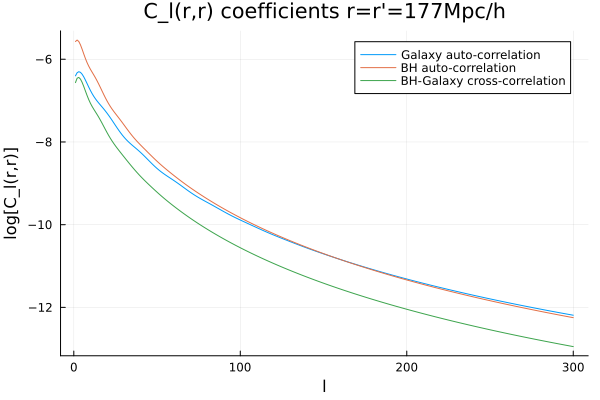

In [29]:
using Plots
plot(ell, [ log.(C2_gg[1,1,:]) , log.(C2_BHBH[1,1,:]) , log.(C2_gBH[1,1,:])], label=["Galaxy auto-correlation" "BH auto-correlation" "BH-Galaxy cross-correlation"])
#100,200

#plot!(xscale=:log10, yscale=:log10, minorgrid=true)
#ylims!(1e+0, 1e+4)
#xlims!(0, 100)
title!("C_l(r,r) coefficients r=r'=177Mpc/h")
xlabel!("l")
ylabel!("log[C_l(r,r)]")

In [36]:
size(C2_gg)

(50, 50, 300)

In [35]:
size(C2_BHBH)

(100, 100, 300)

In [34]:
size(C2_gBH)

(50, 100, 300)

In [37]:
size(r_of_z.(zbins))

(50,)

In [39]:
size(r_of_d.(dlbins))

(100,)

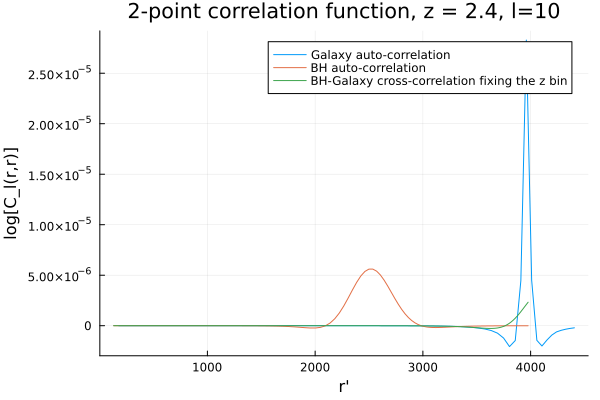

In [40]:
using Plots
plot([r_of_z.(zbins) , r_of_d.(dlbins),r_of_d.(dlbins)], [C2_gg[40,:,10] , C2_BHBH[40,:,10] , C2_gBH[40,:,10]], label=["Galaxy auto-correlation" "BH auto-correlation" "BH-Galaxy cross-correlation fixing the z bin"])
#100,200

#plot!(xscale=:log10, yscale=:log10, minorgrid=true)
#ylims!(1e+0, 1e+4)
#xlims!(0, 100)
title!("2-point correlation function, z = 2.4, l=10")
xlabel!("r'")
ylabel!("log[C_l(r,r)]")

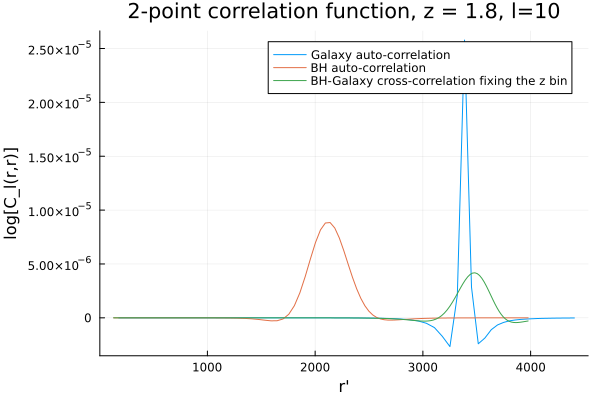

In [177]:
using Plots
plot([r_of_z.(zbins) , r_of_d.(dlbins),r_of_d.(dlbins)], [C2_gg[30,:,10] , C2_BHBH[30,:,10] , C2_gBH[30,:,10]], label=["Galaxy auto-correlation" "BH auto-correlation" "BH-Galaxy cross-correlation fixing the z bin"])
#100,200

#plot!(xscale=:log10, yscale=:log10, minorgrid=true)
#ylims!(1e+0, 1e+4)
#xlims!(0, 100)
title!("2-point correlation function, z = 1.8, l=10")
xlabel!("r'")
ylabel!("log[C_l(r,r)]")

In [ ]:
#this is not correct bin plot again!

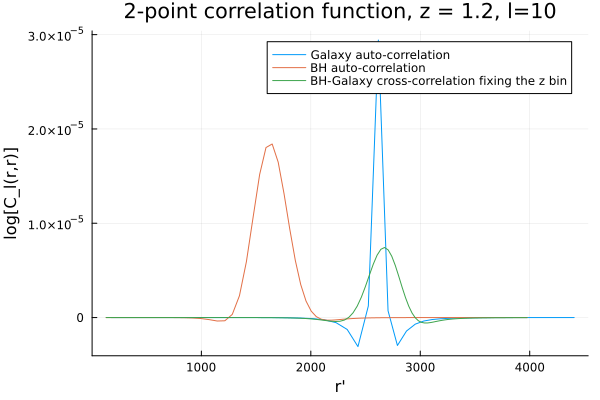

In [179]:
using Plots
plot([r_of_z.(zbins) , r_of_d.(dlbins),r_of_d.(dlbins)], [C2_gg[20,:,10] , C2_BHBH[20,:,10] , C2_gBH[20,:,10]], label=["Galaxy auto-correlation" "BH auto-correlation" "BH-Galaxy cross-correlation fixing the z bin"])
#100,200

#plot!(xscale=:log10, yscale=:log10, minorgrid=true)
#ylims!(1e+0, 1e+4)
#xlims!(0, 100)
title!("2-point correlation function, z = 1.2, l=10")
xlabel!("r'")
ylabel!("log[C_l(r,r)]")

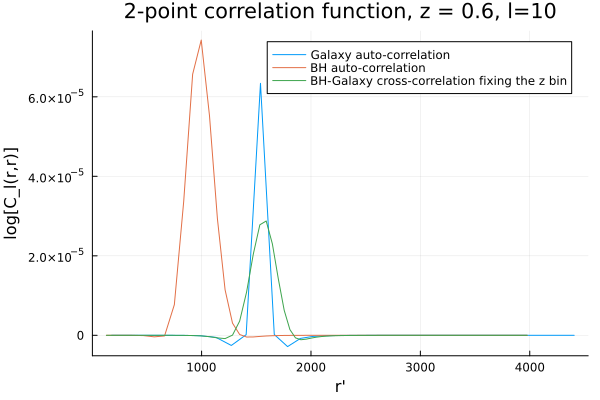

In [180]:
using Plots
plot([r_of_z.(zbins) , r_of_d.(dlbins),r_of_d.(dlbins)], [C2_gg[10,:,10] , C2_BHBH[10,:,10] , C2_gBH[10,:,10]], label=["Galaxy auto-correlation" "BH auto-correlation" "BH-Galaxy cross-correlation fixing the z bin"])
#100,200

#plot!(xscale=:log10, yscale=:log10, minorgrid=true)
#ylims!(1e+0, 1e+4)
#xlims!(0, 100)
title!("2-point correlation function, z = 0.6, l=10")
xlabel!("r'")
ylabel!("log[C_l(r,r)]")

In [166]:
function average_over_3d_lastax(A)
    n = size(A,3)
    m = size(A,1)
    r = size(A,2)
    out = zeros(m,r)
    for l=1:n
        for i=1:m
            for j=1:r
                out[i,j]+=A[i,j,l]
            end
        end
    end
    return out/n;
end;


In [167]:
average_over_3d_lastax(a)

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 2.0  2.5  3.0
 0.0  0.0  3.0

In [169]:
C2_gg_all = average_over_3d_lastax(C2_gg)
C2_gBH_all = average_over_3d_lastax(C2_gBH)
C2_BHBH_all = average_over_3d_lastax(C2_BHBH)

100×100 Matrix{Float64}:
  0.000215795   3.24985e-5   -4.71688e-7   …   6.19506e-28   5.59177e-28
  3.24985e-5    0.000127844   3.08985e-5      -1.23248e-26  -1.13601e-26
 -4.71688e-7    3.08985e-5    8.65934e-5      -3.9694e-25   -3.57657e-25
 -1.79971e-7    4.63421e-7    2.96997e-5      -1.20147e-23  -1.0623e-23
 -2.42065e-8   -3.11666e-7    2.22744e-6      -3.35059e-22  -2.91591e-22
 -2.29819e-9   -1.0602e-7    -2.31617e-7   …  -8.1192e-21   -6.97718e-21
 -1.79189e-10  -3.17757e-8   -1.54503e-7      -1.64764e-19  -1.40272e-19
 -1.36282e-11  -8.49346e-9   -6.89927e-8      -2.73667e-18  -2.3158e-18
 -1.13878e-12  -1.99448e-9   -3.04438e-8      -3.66828e-17  -3.09535e-17
 -1.11205e-13  -4.24958e-10  -1.28984e-8      -3.93607e-16  -3.32217e-16
 -1.29932e-14  -8.61503e-11  -5.10866e-9   …  -3.36892e-15  -2.85246e-15
 -1.82016e-15  -1.73476e-11  -1.88658e-9      -2.30039e-14  -1.9591e-14
 -3.03003e-16  -3.58398e-12  -6.57251e-10     -1.25715e-13  -1.07943e-13
  ⋮                          

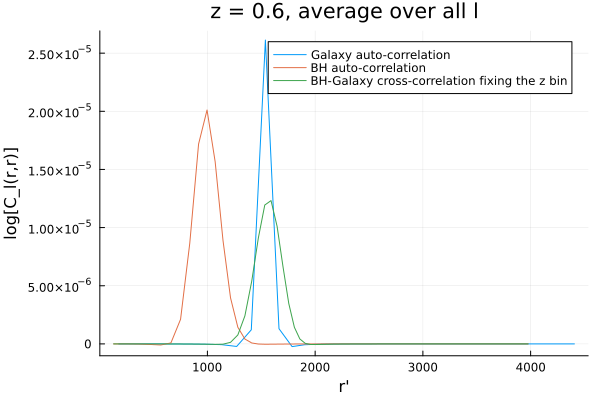

In [181]:
using Plots
plot([r_of_z.(zbins) , r_of_d.(dlbins),r_of_d.(dlbins)], [C2_gg_all[10,:] , C2_BHBH_all[10,:] , C2_gBH_all[10,:]], label=["Galaxy auto-correlation" "BH auto-correlation" "BH-Galaxy cross-correlation fixing the z bin"])
#100,200

#plot!(xscale=:log10, yscale=:log10, minorgrid=true)
#ylims!(1e+0, 1e+4)
#xlims!(0, 100)
title!("z = 0.6, average over all l")
xlabel!("r'")
ylabel!("log[C_l(r,r)]")

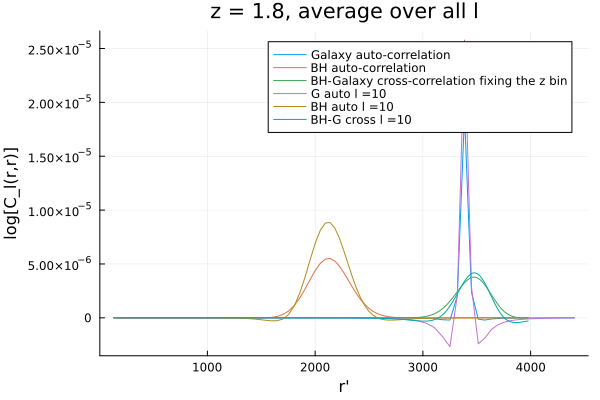

In [182]:
using Plots
plot([r_of_z.(zbins) , r_of_d.(dlbins),r_of_d.(dlbins), r_of_z.(zbins) , r_of_d.(dlbins),r_of_d.(dlbins) ], [C2_gg_all[30,:] , C2_BHBH_all[30,:] , C2_gBH_all[30,:], C2_gg[30,:,10] , C2_BHBH[30,:,10] , C2_gBH[30,:,10]], label=["Galaxy auto-correlation" "BH auto-correlation" "BH-Galaxy cross-correlation fixing the z bin" "G auto l =10" "BH auto l =10" "BH-G cross l =10"])

#100,200

#plot!(xscale=:log10, yscale=:log10, minorgrid=true)
#ylims!(1e+0, 1e+4)
#xlims!(0, 100)
title!("z = 1.8, average over all l")
xlabel!("r'")
ylabel!("log[C_l(r,r)]")

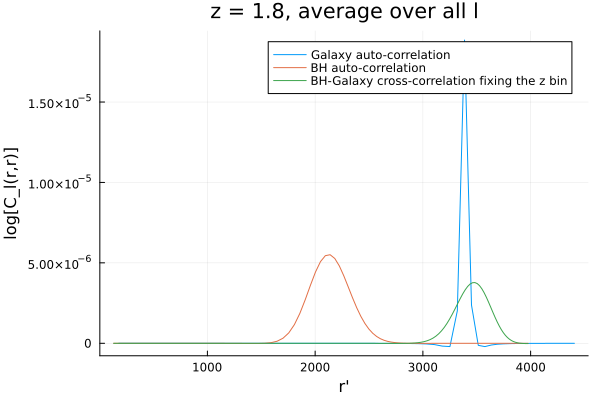

In [183]:
using Plots
plot([r_of_z.(zbins) , r_of_d.(dlbins),r_of_d.(dlbins)], [C2_gg_all[30,:] , C2_BHBH_all[30,:] , C2_gBH_all[30,:]], label=["Galaxy auto-correlation" "BH auto-correlation" "BH-Galaxy cross-correlation fixing the z bin"])
#100,200

#plot!(xscale=:log10, yscale=:log10, minorgrid=true)
#ylims!(1e+0, 1e+4)
#xlims!(0, 100)
title!("z = 1.8, average over all l")
xlabel!("r'")
ylabel!("log[C_l(r,r)]")

# Adding Shot noise

### The shot noise matrix can be constructed as below:

$$\textit{SN}_{150 \times 150} =
\left(
  \begin{array}{c|ccc}
   & & & \\
    [\textit{SN}_{\textit{gg}}]^{50\times50} & & [\textit{SN}_{\textit{gBH}}]^{50\times 100}& \\
   & & &   \\
  \hline
   & & & \\
   & & & \\
   [\textit{SN}_{\textit{gBH}}^T]^{100\times 50} & &  [\textit{SN}_{\textit{BHBH}}]^{100\times100} &\\
   & & & \\
   & & & \\
\end{array} \right)$$

Physical origin of shot noise comes from the fact that the structure formation is not exactly linearly described by a bias, but there is a shot noise that one can see that in the most cases follows a Poisson distribution and thus the error would be inversely proportional to the square root of the number of matter traces:


## Auto-correlation terms:
### $$ \delta_{g/GW} = b_{g/GW} \ \delta_{m} + \epsilon_{g/GW}$$

### where: $ \epsilon_{g/GW} \propto \frac{1}{\sqrt{N_{g/GW}}}$

And then the shot noise term in the two point correaltion functions can be written as:

### $<\delta_{g/GW}\delta_{g/GW}> = |b_{g/GW}|^2 \ <\delta_{m}\delta_{m}> + <\epsilon_{g/GW}\epsilon_{g/GW}>$ $\rightarrow \textit{SN}_{gg/GW} = \ <\epsilon_{g/GW}\epsilon_{g/GW}>\ \propto \frac{1}{N_{g/GW}}$


## Cross-correlation terms:
### $<\delta_{g}\delta_{GW}> = |b_{g}b_{GW}| \ <\delta_{m}\delta_{m}> + <\epsilon_{g}\epsilon_{GW}>$ $\rightarrow$
#### The only terms that will contribute to the shot noise of the cross-correlation term are the terms related to the noise of the BHs which have a host in our galaxy catalog. This is because we're assuming that the shot noise term at each position r is independent of all of the r', meaning that the only none zero shot noise terms are the ones that:  $<\epsilon_{g}(r)\epsilon_{GW}(r')>$ for $r= r'$

### $\textit{SN}_{gBH} = \ <\epsilon_{g}\epsilon_{GW}>\ \propto \frac{1}{N_{cross}}$

### With this discussion I will construct the shot noise term in the following.

In [44]:
#this is actually <e_g e_g>
SN_gg = Diagonal(1.0 ./ ng_obs); #shape: nb*nb

#this is actually <e_GW e_GW>
SN_BHBH = Diagonal(1.0 ./ nBH_obs);

#This is actually 
SN_gBH = SN_gg * gal_proj * Diagonal(ncross_intrinsic) * BH_proj' * SN_BHBH';
SN = [SN_gg SN_gBH ; SN_gBH' SN_BHBH];

In [47]:
size(SN_gBH)

(50, 100)

# Adding the Localization Error on the GW events

### We need to convolve the maps to take into account a localization error due to the poor localization of the GW events and the localization error in the galaxy map. 

We here assume that the localization error for the galaxy catalog is so small compared to the GW catalog that we don't need to convolve our map to take in account the localization error for the galaxy catalog. Thus the only map that we will convolve would be the BHBH map and the cross-correlation map.

Convolution in the Fourier space just acts like a multiplication.
Let's say that we have a Gaussian kernel with kernel width of $\sigma_{RA}$, convolution of the map M(x) by this gaussian kernel would be:

$[W*M](y)$= $\int dx \ M(x)$ $exp[\frac{-(x-y)^2}{2 \sigma_{RA}^2}] $

Fourier transform of this convolution would be:

FT($W*M$)($l$) = $\hat{M}(l)$ $exp[\frac{-l^2  \sigma_{RA}^2 }{2}] $

And thus calculating the localization error would be super easy as we just need to multiply by a gaussian function.

After that one can write the coefficients $C_l(r,r')$ only as a function of $r,r'$ by suming over all of the spherical harmonics. Because of the degeneracy of $m$, we in total has $(2l+1)$ coefficients with the same $l$. 

In general the localization error is a function of the mass of the binary black hole and is not a constant as the larger the BBH be the event would be louder and thus the localization arror would reduce. It means that we have: $\sigma_{RA} = \sigma_{RA}(M_{BBH})$

Thus one can average over the $C_l$ coefficients for each mass bin seperatly as below:

$$ C_{Mass}(r,r') = \sum_{l=0}^{l_{max}} \ (2l+1) C_{l,Mass}(r,r') \ exp[\frac{(l \sigma_{RA(M_{BBH})})^2}{2}]$$

But now this means that we need to make our maps in a way that contains the mass distribution of the BBHs. Meaning that we need to have different maps for different BBH masses that forces us to assume an astrophysical process in order to be able to do this, or assume a constant distribution of BBH mass.

In [43]:
a = [1 2]
b = [3 4]
c = [a b]
c

1×4 Matrix{Int64}:
 1  2  3  4

# Calculating the covariance matrix

error on the 2-point correlation function for the cosmic variant measurement it's just inversely proportional to the square root of the 2-point correlation function itself.

We have another shot noise coming from cosmology for assuming a linear bias.



# Fisher Matrix Calculation